In [1]:
import sys
print(sys.version)

3.9.17 (main, Jul  5 2023, 20:41:20) 
[GCC 11.2.0]


In [2]:
# pip install fastai

In [3]:
import fastai
print(fastai.__version__)  # Check the installed version

2.7.18


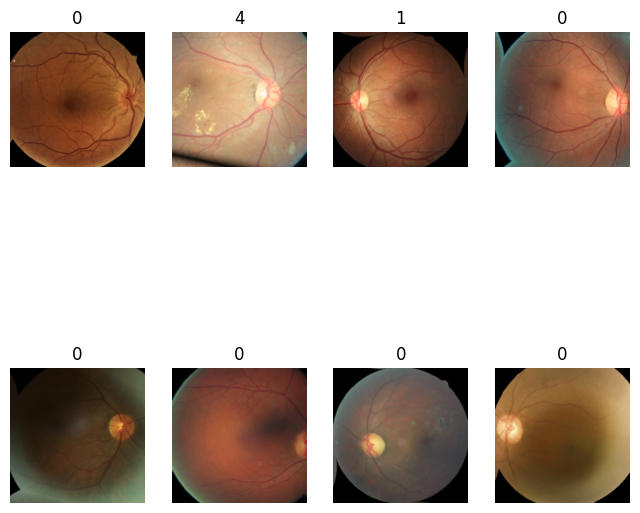

In [3]:
# Import required libraries
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Input: Image, Target: Category
    get_items=get_image_files,  # Get all image files in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Split 80% train, 20% validation
    get_y=parent_label,  # Extract labels from parent folder names
    item_tfms=Resize(460),  # Resize images to 460 before batching
    batch_tfms=aug_transforms(size=224)  # Apply augmentations and resize to 224x224
)

# Create DataLoaders
path = Path('data/train15')  # Path to your dataset
dls = dblock.dataloaders(path, bs=8, num_workers=0)  # Batch size of 32

# Display a batch of images
# dls.show_batch(max_n=9, figsize=(8, 8))

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class EyeDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(EyeDiseaseClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        return self.fc2(x)


In [4]:
# Define a function to calculate precision, recall, and F1-score
def calculate_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1)
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return precision, recall, f1

In [5]:
# Define the training function
def train_model(model, dls, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        precision_sum, recall_sum, f1_sum = 0, 0, 0

        for inputs, labels in dls.train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (torch.max(outputs, 1)[1] == labels).sum().item()
            total += labels.size(0)

            precision, recall, f1 = calculate_metrics(outputs, labels)
            precision_sum += precision * inputs.size(0)
            recall_sum += recall * inputs.size(0)
            f1_sum += f1 * inputs.size(0)
            
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        epoch_precision = precision_sum / total
        epoch_recall = recall_sum / total
        epoch_f1 = f1_sum / total

        print(f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, '
              f'Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}')

In [6]:
# Initialize the model, loss function, and optimizer
model = EyeDiseaseClassifier(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train the model
# train_model(model, dls, criterion, optimizer)

In [8]:
from sklearn.metrics import precision_score, recall_score

# Custom precision with zero_division handling
def precision_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='macro', zero_division=1)

# Custom recall (optional, keeping it aligned with precision handling)
def recall_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='macro', zero_division=1)

In [9]:
# Step 3: Create the Learner
model = EyeDiseaseClassifier(num_classes=5)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=Adam, metrics=[accuracy, precision_macro, recall_macro])

# Step 4: Train the Model
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,precision_macro,recall_macro,time
0,0.895693,0.861521,0.741495,0.902679,0.456095,31:01
1,0.896387,0.847874,0.741495,0.902679,0.456095,32:22
2,0.915306,0.846568,0.741495,0.902679,0.456095,34:39
3,0.819861,0.845584,0.741495,0.902679,0.456095,36:39
4,0.878353,0.846687,0.741495,0.902679,0.456095,36:51


In [ ]:
learn.show_results(max_n=9, figsize=(8, 8))

In [10]:
# Save the state_dict (model parameters)
torch.save(model.state_dict(), "models/v1.4_vgg16_model.pth")

v1.3vgg16_model.pth
